In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim

from src.utils import *
from src.override_resnet import *

import matplotlib.pyplot as plt

def fuse_model(model) -> nn.Module:
    SingleTimeFlag = False
    for m in model.modules():
        if m.__class__.__name__ == ResNet_quan.__name__:
            if SingleTimeFlag == True:
                raise ValueError("ResNet_quan is already fused")
            SingleTimeFlag = True
            torch.quantization.fuse_modules(
                m,
                ["conv1", "bn1", "relu"],
                inplace=True,
            )

        if type(m) == BottleNeck_quan:

            torch.quantization.fuse_modules(
                m,
                [
                    ["conv1", "bn1", "relu1"],
                    ["conv2", "bn2", "relu2"],
                    ["conv3", "bn3"],
                ],
                inplace=True,
            )
            if m.downsample is not None:
                torch.quantization.fuse_modules(
                    m.downsample,
                    ["0", "1"],
                    inplace=True,
                )
    return model



device = "cpu"
model = resnet50_quan(weights=pretrained_weights_mapping[50]).to(device)


In [2]:
def show_plot(_weights, _name):
    if type(_weights) == torch.Tensor:
        _tmp = copy.deepcopy(_weights)
        _tmp = _tmp.flatten().numpy()

    else:
        _tmp = copy.deepcopy(_weights)
        _tmp = _tmp.weight().int_repr().numpy()
        _tmp = _tmp.astype(float)
        _tmp = _tmp.flatten()

    plt.hist(_tmp.flatten(), bins=256)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {_name}")
    plt.show()
    print(_tmp.min(), _tmp.max(), _tmp.mean(), _tmp.std())

# 1. The Acc of Reference Network

- Check the origin network architecture

In [3]:
print(model.layer1[0])
# check_accuracy(model=model, device="cpu", batch_size=25)
print("Post Training Quantization: Eval done")

BottleNeck_quan(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (add): FloatFunctional(
    (activation_post_process): Identity()
  )
)
Post Training Quantization: Eval done


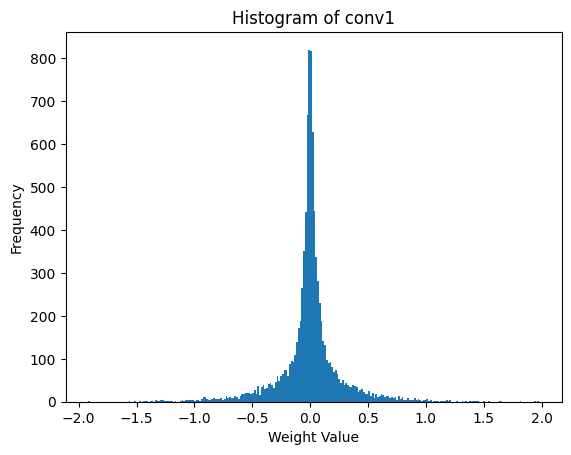

-1.9180801 1.9789636 -0.0006088594 0.26923782


In [4]:
__conv1 = model.conv1.weight.data
show_plot(__conv1, "conv1")

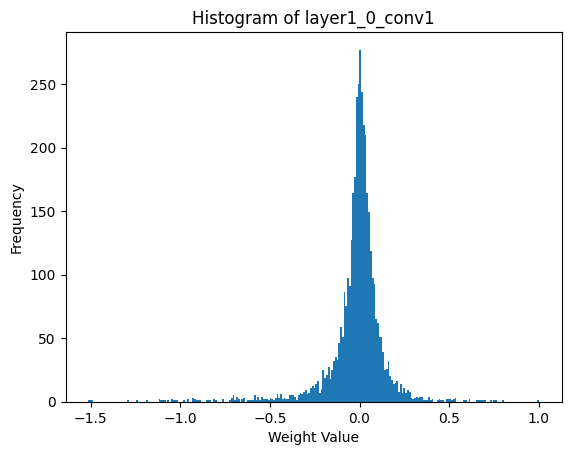

-1.5129721 1.0011052 -0.015311795 0.16769269


In [5]:
__layer1_0_conv1 = model.layer1[0].conv1.weight.data
show_plot(__layer1_0_conv1, "layer1_0_conv1")

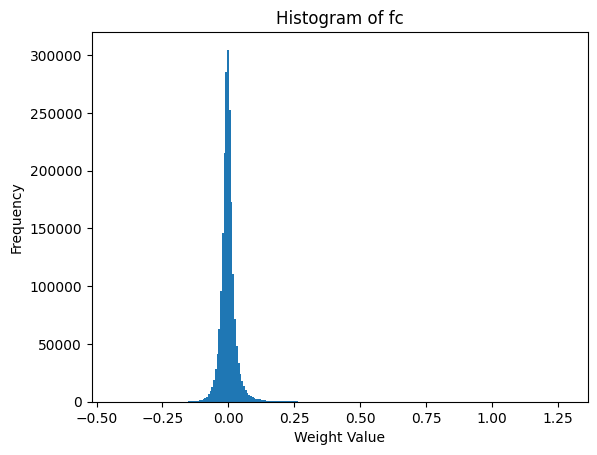

-0.43231362 1.2790387 9.732936e-07 0.040513273


In [6]:
__fc = model.fc.weight.data
show_plot(__fc, "fc")

- Check the fused network architecture

In [7]:
model.eval()
model = fuse_model(model)
print(print_size_of_model(model))
print(model.layer1[0])

Size (MB): 102.158986
102.158986
BottleNeck_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (bn1): Identity()
  (conv2): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn2): Identity()
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn3): Identity()
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Identity()
  )
  (relu1): Identity()
  (relu2): Identity()
  (relu3): ReLU()
  (add): FloatFunctional(
    (activation_post_process): Identity()
  )
)


In [8]:
print(model.modules)

<bound method Module.modules of ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (bn1): Identity()
      (conv2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (bn2): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): Identity()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Identity()
      )
      (relu1): Identity()
      (relu2): Identity()
      (relu3): ReLU()
      (add): FloatFunc

# 2. Calibration for Post-Training Static Quantization

- Check the Quantization Configuration

In [9]:
# model.conv1.qconfig = torch.quantization.QConfig(
#     activation=torch.quantization.PlaceholderObserver.with_args(dtype=torch.qint8),
#     weight=torch.quantization.PlaceholderObserver.with_args(dtype=torch.qint8),
# )

model.conv1.qconfig = None
model.qconfig = torch.quantization.get_default_qconfig("x86")
# model.qconfig = torch.quantization.get_default_qconfig("x86")
print("Post Training Quantization Prepare: Inserting Observers")

Post Training Quantization Prepare: Inserting Observers


In [10]:
torch.quantization.prepare(model, inplace=True)

print("Post Training Quantization Prepare: Inserting Observers")

Post Training Quantization Prepare: Inserting Observers


/home/lee/miniconda3/envs/py312/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [11]:
# 모델의 모든 모듈을 순회합니다.
for name, module in model.named_modules():
    # 모듈의 qconfig 속성을 확인합니다.
    if hasattr(module, "qconfig") and module.qconfig is not None:
        print(f"Module {name} has qconfig: {module.qconfig}")
    else:
        print(f"Module {name} does not have a qconfig")

Module  has qconfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x74eb6b42c180>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x74eb6b42c180>})
Module conv1 does not have a qconfig
Module conv1.0 does not have a qconfig
Module conv1.1 does not have a qconfig
Module bn1 has qconfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x74eb65f627a0>}, weight=functools.partial(<class 'torch.ao.quantization.observer.Per

- Inference with the representative dataset (calculate the quantization parameters)

In [12]:
criterion = nn.CrossEntropyLoss()
train_loader, test_loader = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=256,
    num_workers=8,
)
_, _ = SingleEpochEval(model, train_loader, criterion, "cuda", 2)
print("Post Training Quantization: Calibration done")

  0%|          | 1/5005 [00:03<5:06:37,  3.68s/it]

Post Training Quantization: Calibration done


In [13]:
model.to("cpu")

torch.quantization.convert(model, inplace=True)

ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.13715146481990814, zero_point=0)
      (bn1): Identity()
      (conv2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.18796640634536743, zero_point=0, padding=(1, 1))
      (bn2): Identity()
      (conv3): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=0.279589980840683, zero_point=68)
      (bn3): Identity()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=0.4388507008552551, zero_point=80)
        (1): Identity()
      )
      (relu1): Identity()
 

- Convert to quantized model

In [14]:
print_size_of_model(model)

Size (MB): 26.177596


26.177596

# 3. Complete 

In [15]:
check_accuracy(model=model, device="cpu", batch_size=25)
print("Post Training Quantization: Eval done")

Elapsed time:  23 ms
Size (MB): 26.177596


 25%|██▍       | 499/2000 [02:45<08:17,  3.02it/s]

Eval Loss: 1.2510, Eval Acc: 85.34%
Post Training Quantization: Eval done


In [17]:
26.177596 - 26.151272

0.026324000000002457

In [19]:
3*64*3*3*32*3/4

41472.0

In [16]:
# 가중치를 가져옵니다.
__q__conv1 = model.conv1.weight().int_repr()
show_plot(__q__conv1, "conv1")

AttributeError: 'ConvReLU2d' object has no attribute 'weight'

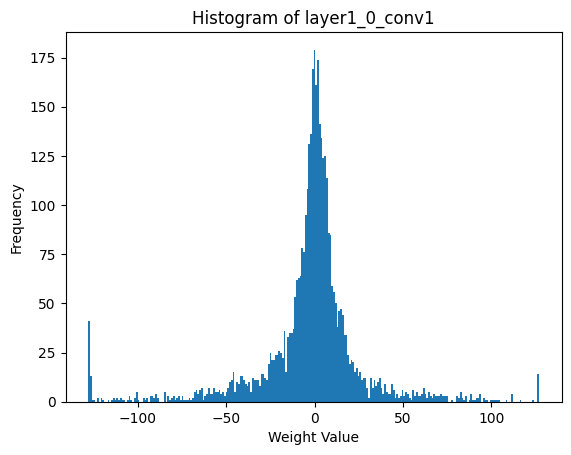

-128 127 -2.330078125 30.754166917775493


In [ ]:
# 가중치를 가져옵니다.
__q__layer1_0_conv1 = model.layer1[0].conv1.weight().int_repr()
show_plot(__q__layer1_0_conv1, "layer1_0_conv1")

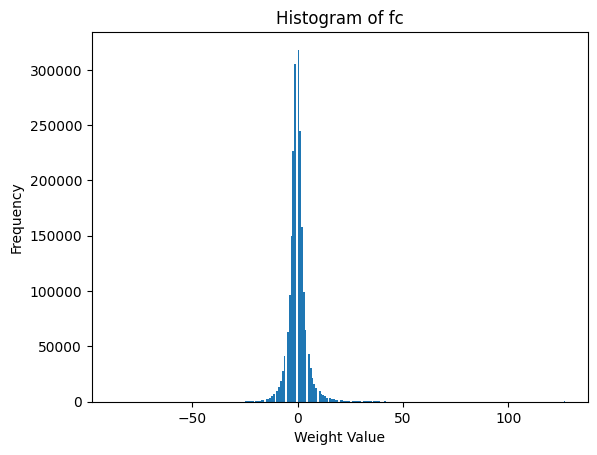

-87 127 -0.0043212890625 6.162057292533139


In [ ]:
# 가중치를 가져옵니다.
__q__fc = model.fc.weight().int_repr()
show_plot(__q__fc, "fc")

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.quantization as quantization

model = resnet50_quan(weights=pretrained_weights_mapping[50]).to(device)

# Identify the modules to quantize
modules_to_quantize = [model.layer1, model.layer2, model.layer3, model.layer4]

# Define qconfig for quantization
qconfig = quantization.get_default_qconfig("x86")

# Prepare the model for quantization-aware training
model.qconfig = qconfig
quantization.prepare(model, inplace=True)


ResNet_quan(
  (conv1): Conv2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): Conv2d(
        64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
        (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
      )
      (bn1): BatchNorm2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
      )
      (conv2): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (act

In [ ]:

# Apply quantization to the selected modules
for module in modules_to_quantize:
    quantization.convert(module, inplace=True)


# Print the quantized model
print(model)
print_size_of_model(model)

/home/lee/miniconda3/envs/py312/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1263: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


ResNet_quan(
  (conv1): Conv2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
      (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
      (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): QuantizedConv2d(64

32.742238